In [1]:
%load_ext autoreload
%autoreload 2

On Colab, you will need to clone and install [probabll/dists.pt](https://github.com/probabll/dists.pt.git)

In [2]:
import torch
torch.__version__

'1.8.1+cu102'

In [3]:
import numpy as np
import torch
import torch.distributions as td
import probabll.distributions as pd
import matplotlib.pyplot as plt
import torch.nn as nn

In [4]:
from collections import namedtuple, OrderedDict, defaultdict
from tqdm.auto import tqdm
from itertools import chain
from tabulate import tabulate

In [5]:
import sys
sys.path.append("../")

In [6]:
from components import GenerativeModel, InferenceModel, VAE
from data import load_mnist
from hparams import load_cfg, make_args
from main import make_state, get_batcher, validate

In [7]:
from analysis import compare_marginals, compare_samples

# Load model and data

* Load hyperparameters
* Load model state
* Load MNIST data

In [8]:
num_samples = 100

In [9]:
ls ../neurips-mixed-rv/supp/mixed-maxent/neat-shape-14/

cfg.json  ckpt.best  ckpt.last


In [10]:
#directory = 'neurips-mixed-rv/mixed-vae/test-new-sharing/breezy-fog-49/'
#directory = 'neurips-mixed-rv/submission/deft-tree-32'
#directory = 'neurips-mixed-rv/submission/icy-sponge-36'
#experiment = 'hopeful-puddle-2'
#experiment = 'neat-shape-14'
experiment = 'comfy-frost-31'
directory = f'../neurips-mixed-rv/supp/mixed-maxent/{experiment}/'
args = make_args(
    load_cfg(
        f"{directory}/cfg.json", 
        # use this to specify a decide for analysis
        device='cuda:1',
        # use this to change paths if you need
        data_dir='../tmp',
        # you don't really need to change the output_dir
        #batch_size=10,
    )
)
args

Overriding device to user choice cuda:1
Overriding data_dir to user choice ../tmp


Config(seed=10, batch_size=100, data_dir='../tmp', height=28, width=28, output_dir='neurips-mixed-rv/supp/mixed-maxent/comfy-frost-31', device='cuda:1', y_dim=10, prior_f='gibbs-max-ent 0', prior_y='dirichlet 1.0', z_dim=0, hidden_dec_size=500, posterior_f='gibbs -10 10', posterior_y='dirichlet 1e-3 1e3', mean_field=True, hidden_enc_size=500, epochs=200, num_samples=100, gen_opt='adam', gen_lr=0.0001, gen_l2=0.0, gen_p_drop=0.0, inf_opt='adam', inf_lr=0.0002, inf_l2=1e-06, inf_p_drop=0.1, grad_clip=1.0, use_self_critic=1, use_reward_standardisation=0, project='supp-mixed', prior_z='gaussian 0.0 1.0', posterior_z='gaussian', shared_enc_fy=1, training_samples=1, load_ckpt=None, reset_opt=False, exact_marginal=False, exact_KL_Y=0, tqdm=False, cfg='cfg/mixed-vae-shared.json', wandb_freq=10, lr_warmup=0, ppo_like_steps=5, gsp_cdf_samples=100, gsp_KL_samples=1)

In [11]:
state = make_state(
    args, 
    device=args.device, 
    # change this to .best if you want the best ckpt (rather than the last)
    ckpt_path=f"{directory}/ckpt.last"
    #ckpt_path=f"{directory}/training.ckpt"
)

In [12]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to=args.data_dir, 
    height=args.height, 
    width=args.width
)

In [13]:
val_metrics = validate(state.vae, get_batcher(valid_loader, args), 1000, progressbar=True)
print(f'Saved ckpt - Validation: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Saved ckpt - Validation: nll=109.43 bpd=15.79


In [14]:
import pickle
knn_model = pickle.load(open('knnclassifier.pickle', 'rb'))

In [15]:
from analysis import collect_samples

In [16]:
prior, posterior = collect_samples(
    state.vae, 
    get_batcher(valid_loader, args), 
    args, 
    num_samples=1, 
    data_sample=True,
    from_prior=True,
    from_posterior=False,
)

In [17]:
x_gen_prior = np.concatenate(prior['x'])
x_gen_prior.shape

(5000, 784)

In [18]:
knn_pred = knn_model.predict(x_gen_prior)

In [19]:
clustered = defaultdict(list)
for x_, y_ in zip(x_gen_prior, knn_pred):
    clustered[y_].append(x_)
clustered = {cls: np.stack(digits) for cls, digits in clustered.items()}

In [20]:
p_emp = np.array([len(clustered.get(c, []))/x_gen_prior.shape[0] for c in range(10)])

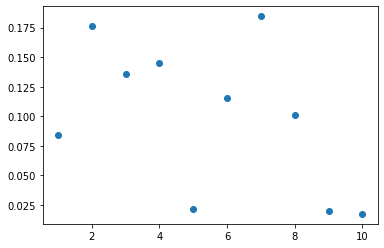

In [21]:
_ = plt.plot(np.arange(10) + 1, p_emp, 'o')

In [22]:
# KL(p_emp||U) and KL(U||p_emp)
kl1 = (p_emp * (np.log(p_emp) - np.log(0.1))).sum(0)
kl2 = (0.1 * (np.log(0.1) - np.log(p_emp))).sum(0)
print(tabulate([[kl1, kl2, (kl1+kl2)/2]], headers=['KL from uniform', 'KL from empirical', 'JS']))

  KL from uniform    KL from empirical        JS
-----------------  -------------------  --------
         0.215951             0.309641  0.262796


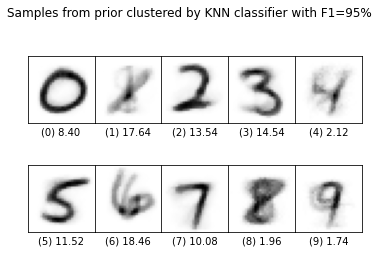

In [23]:
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(clustered.get(c, np.zeros((1, 28 * 28))).mean(0).reshape(args.height, args.width), cmap='Greys')
    axs[c // 5, c % 5].set_xlabel(f"({c}) {p_emp[c] * 100:.2f}") #set_title(f"X'|X={c}")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
_ = fig.suptitle(r'Samples from prior clustered by KNN classifier with F1=95%')

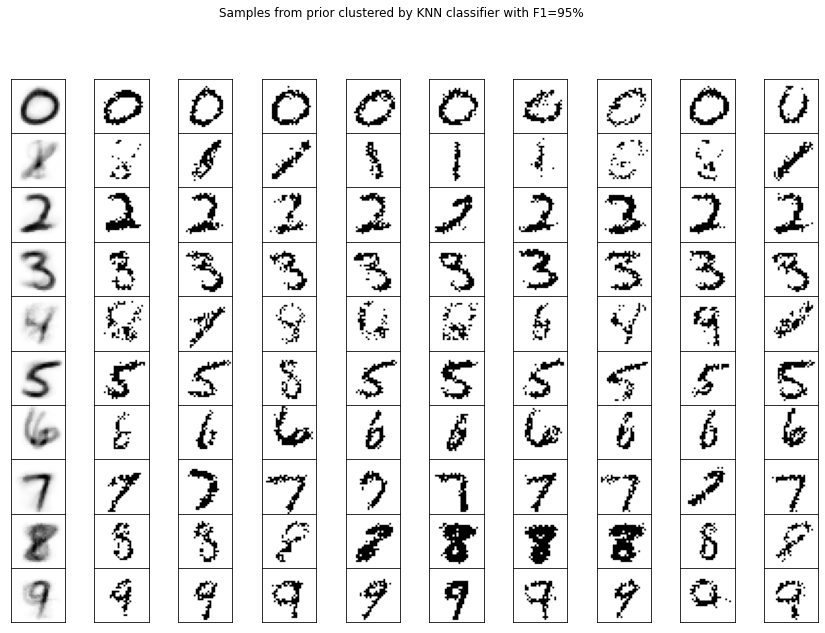

In [24]:
fig, axs = plt.subplots(
    10, 10, 
    figsize=(15, 10),
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0},
)
for c in range(10):
    axs[c, 0].imshow(clustered.get(c, np.zeros((1, 28 * 28))).mean(0).reshape(args.height, args.width), cmap='Greys')    
    for i, k in enumerate(np.random.choice(len(clustered.get(c, [])), size=9)):
        axs[c, i + 1].imshow(clustered[c][k].reshape(args.height, args.width), cmap='Greys')

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
_ = fig.suptitle(r'Samples from prior clustered by KNN classifier with F1=95%')

In [25]:
def density_estimation(vae, valid_batcher, train_batcher, batch_size_y, variable, progressbar=False):
    """
    Return average NLL
        average number of bits per dimension
        and a dictionary with distortion and rate estimates
        
        
    Estimate density of some given z
    """
    prior, posterior = collect_samples(vae, valid_batcher, args, num_samples=1)
            
    if variable not in ['y', 'z']:
        raise ValueError('Either y or z')
        
    # [N, K]
    y = torch.tensor(np.concatenate(posterior[variable], 0))
    # list of [batch_size_y, K]
    batches_y = torch.split(y, batch_size_y, dim=0)
    log_ratios = []  
    
    with tqdm(total=len(batches_y) * len(train_batcher)) as pbar:
        for batch_y in batches_y:
            with torch.no_grad():
                vae.eval()

                nb_obs = 0
                nb_bits = 0.
                ll = 0.
                DR = OrderedDict()
                #iterator = tqdm(train_batcher) if progressbar else iter(train_batcher)
                log_q = 0.
                log_p = 0.
                for x_obs, c_obs in train_batcher:
                    # [B, H*W]
                    x_obs = x_obs.reshape(-1, vae.p.data_dim)  
                    if variable == 'y':
                        lq_, lp_ = vae.density_estimation_y(x_obs, batch_y.to(torch.device(args.device)), reduce='sum')
                    else:
                        lq_, lp_ = vae.density_estimation_z(x_obs, batch_y.to(torch.device(args.device)), reduce='sum')
                    log_q = log_q + lq_.cpu().numpy()
                    log_p = log_p + lp_.cpu().numpy()
                    nb_obs += x_obs.shape[0]
                    pbar.update(1)
                    
                # [batch_size_y]
                log_ratios.append((log_q - log_p) / nb_obs)
    return np.concatenate(log_ratios)

In [26]:
K3 = density_estimation(
    state.vae, 
    get_batcher(valid_loader, args),  # we MC estimate KL(q(y)||p(y)) by sampling x~dev, y|x ~ infnet
    get_batcher(valid_loader, args),  # we estimate log q(y) via mean(log q(y|x) for x in training)
    batch_size_y=200, 
    variable='z',
    progressbar=True
)

  0%|          | 0/1250 [00:00<?, ?it/s]

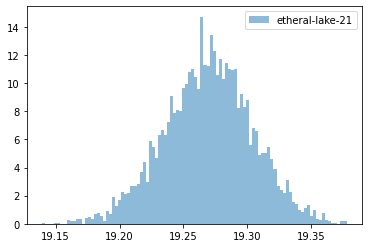

In [27]:
#_ = plt.hist(K, density=True, alpha=0.5, bins=100, label='hopeful-puddle-2')
#_ = plt.hist(K2, density=True, alpha=0.5, bins=100, label='neat-shape-14')
_ = plt.hist(K3, density=True, alpha=0.5, bins=100, label='etheral-lake-21')
_ = plt.legend()

In [28]:
test_metrics = validate(state.vae, get_batcher(test_loader, args), 1000, compute_DR=True, progressbar=True)
print(f'Saved ckpt - Test: nll={test_metrics[0]:.2f} bpd={test_metrics[1]:.2f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Saved ckpt - Test: nll=108.56 bpd=15.66


In [29]:
rows = [('IS-NLL', test_metrics[0], None), ('IS-BPD', test_metrics[1], None)]
for k, v in test_metrics[2].items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric          mean       std
--------  ----------  --------
IS-NLL     108.562
IS-BPD      15.6622
ELBO      -111.339    34.205
D           91.9654   31.1771
R           19.3738    4.84998
R_F         10.0768    2.16486
R_Y|f        9.29698   2.78978


# Training Curves

In [30]:
np_stats_tr = {k: np.array(v) for k, v in state.stats_tr.items()}
np_stats_val = {k: np.array(v) for k, v in state.stats_val.items()}

In [31]:
def smooth(v, kernel_size=100):
    if kernel_size is None:
        return v
    return np.convolve(v, np.ones(kernel_size)/kernel_size, 'valid')

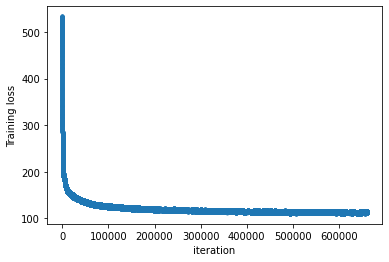

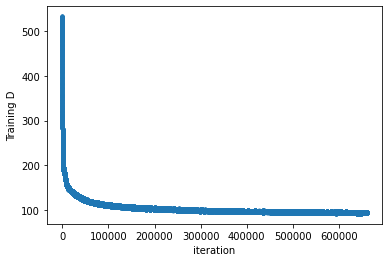

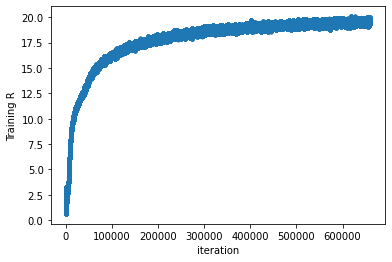

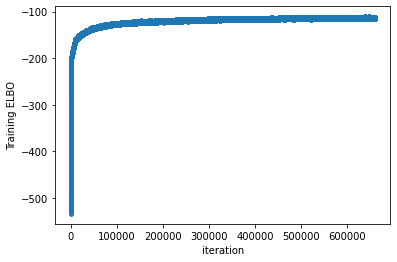

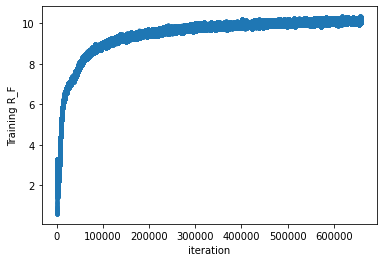

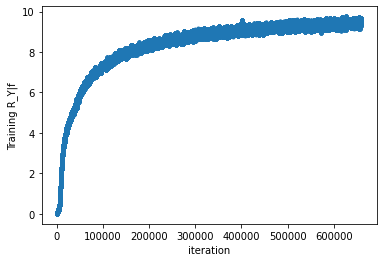

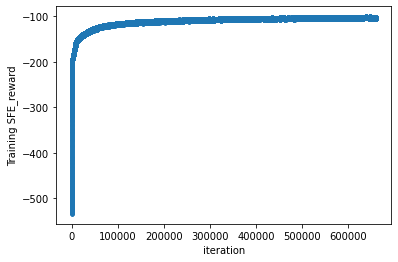

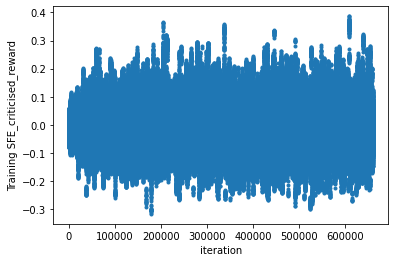

In [32]:
for k, v in np_stats_tr.items():
    v = smooth(v)
    plt.plot(np.arange(1, v.size + 1), v, '.')    
    plt.ylabel(f'Training {k}')
    plt.xlabel('iteration')
    plt.show()

# Validation Curves

In [33]:
print(tabulate(
    [(k, np.mean(v[-100:]), np.min(v[-100:])) for k, v in np_stats_val.items()],
    headers=['metric', 'mean', 'min']
))

metric           mean         min
---------  ----------  ----------
val_nll     111.11      109.561
val_bpd      16.0298     15.8064
val_ELBO   -113.34     -115.351
val_D        94.2888     92.481
val_R        19.0513     18.4047
val_R_F       9.96039     9.72941
val_R_Y|f     9.09091     8.67533


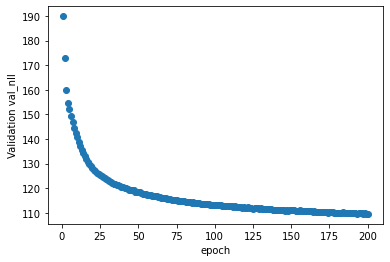

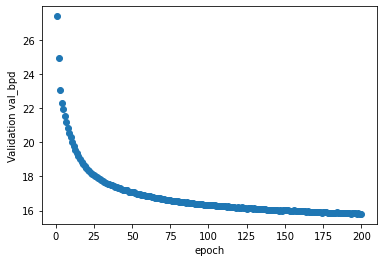

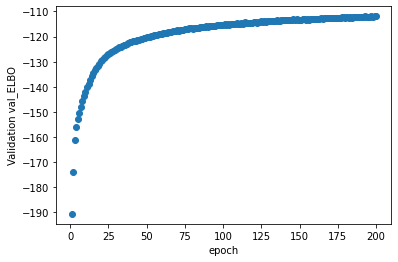

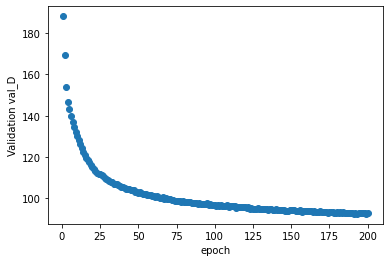

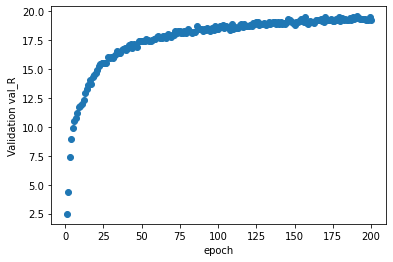

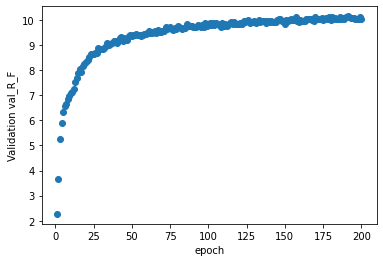

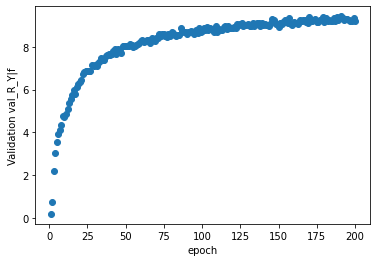

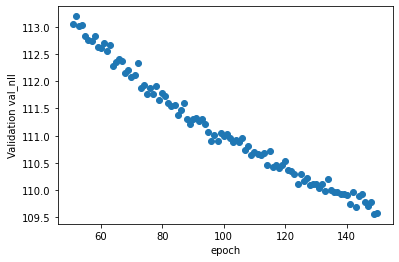

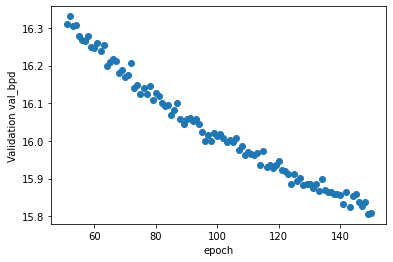

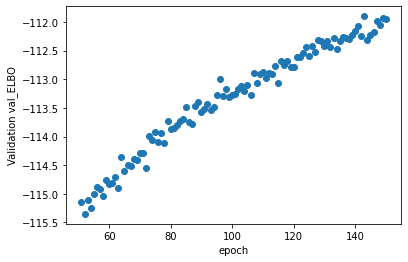

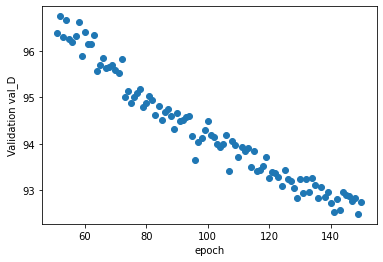

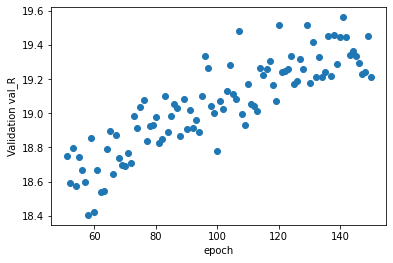

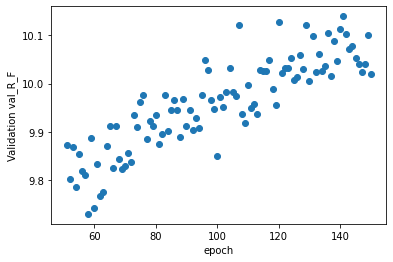

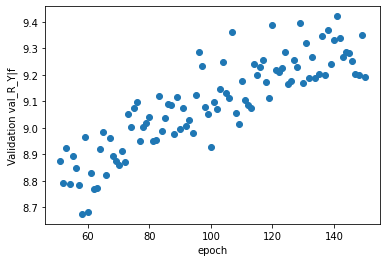

In [34]:
for k, v in np_stats_val.items():
    plt.plot(np.arange(1, v.size + 1), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()
for k, v in np_stats_val.items():
    v = v[v.size//2:]
    plt.plot(np.arange(1 + v.size//2, v.size + 1 + v.size//2), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()    

In [35]:
val_nll, val_bpd, val_DR = validate(
    state.vae, get_batcher(valid_loader, args), num_samples, compute_DR=True, progressbar=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [36]:
rows = [('IS-NLL', val_nll, None), ('IS-BPD', val_bpd, None)]
for k, v in val_DR.items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric          mean       std
--------  ----------  --------
IS-NLL     109.818
IS-BPD      15.8434
ELBO      -112.087    33.9351
D           92.8089   30.8683
R           19.2783    4.8509
R_F         10.0384    2.16642
R_Y|f        9.23989   2.78993


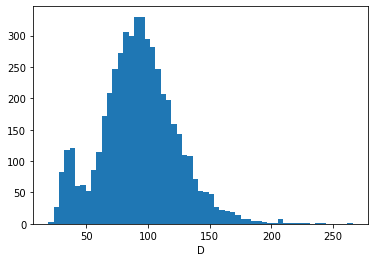

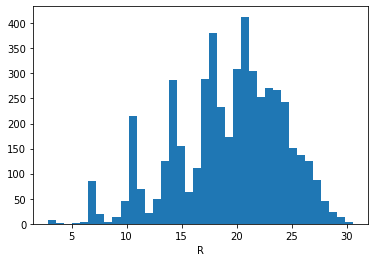

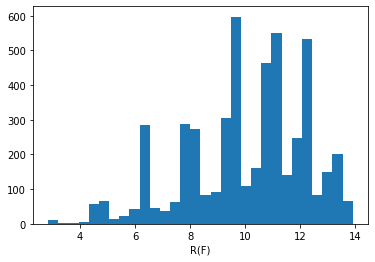

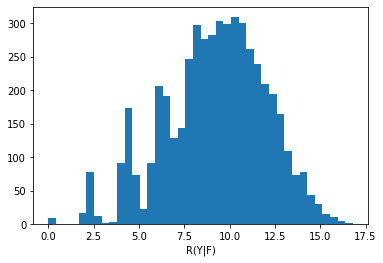

In [37]:
_ = plt.hist(val_DR['D'], bins='auto')
_ = plt.xlabel('D')
plt.show()

_ = plt.hist(val_DR['R'], bins='auto')
_ = plt.xlabel('R')
plt.show()

if state.vae.p.z_dim:
    _ = plt.hist(val_DR['R_Z'], bins='auto')
    _ = plt.xlabel('R(Z)')
    plt.show()
    
if state.vae.p.y_dim:
    _ = plt.hist(val_DR['R_F'], bins='auto')
    _ = plt.xlabel('R(F)')
    plt.show()

    _ = plt.hist(val_DR['R_Y|f'], bins='auto')
    _ = plt.xlabel('R(Y|F)')
    plt.show()

# Analysis

In [38]:
import torch_two_sample as t2s
from analysis import collect_samples

In [39]:
prior, posterior = collect_samples(state.vae, get_batcher(valid_loader, args), args, num_samples=10)

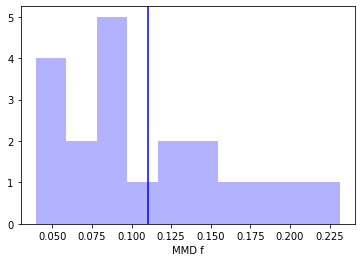

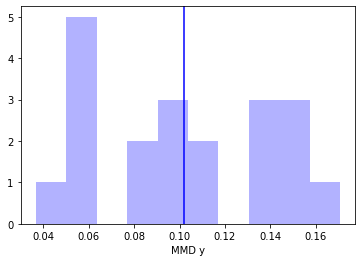

In [40]:
for rv, dim in [('f', state.p.y_dim), ('y', state.p.y_dim), ('z', state.p.z_dim)]:
    if dim == 0:
        continue
    p_f = np.stack(prior[rv]).reshape(-1, dim)
    q_f = np.stack(posterior[rv]).reshape(-1, dim)
    mmd = t2s.statistics_diff.MMDStatistic(p_f.shape[0], q_f.shape[0])
    v = np.array([mmd(torch.tensor(p_f), torch.tensor(q_f), [alpha]).cpu().numpy() for alpha in np.random.gamma(10., 1./10, size=20)])

    _ = plt.hist(v, color='blue', alpha=0.3, label='')
    _ = plt.axvline(x=v.mean(), c='blue')
    #_ = plt.hist(v2, color='red', alpha=0.3, label='volcanic-firefly-4')
    #_ = plt.axvline(x=v2.mean(), c='red')
    _ = plt.xlabel(f"MMD {rv}")
    plt.show()

In [41]:
#v2 = np.array([mmd(torch.tensor(p_f), torch.tensor(q_f), [alpha]).cpu().numpy() for alpha in np.random.gamma(10., 1./10, size=100)])

## KL

For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


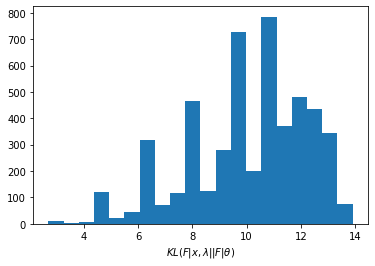

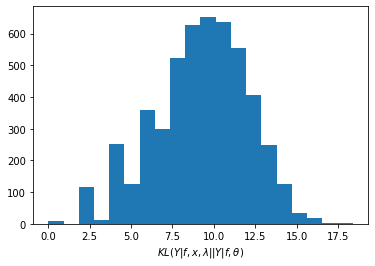

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


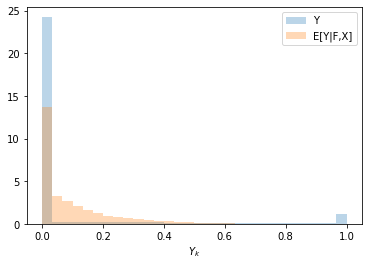

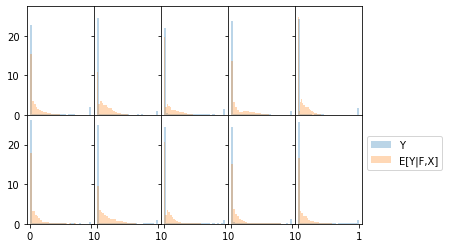

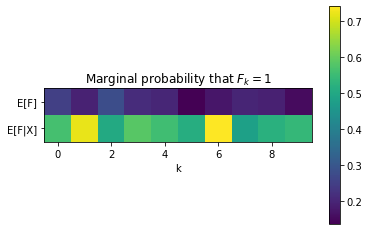

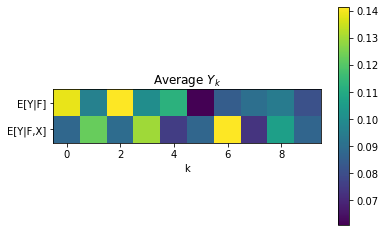

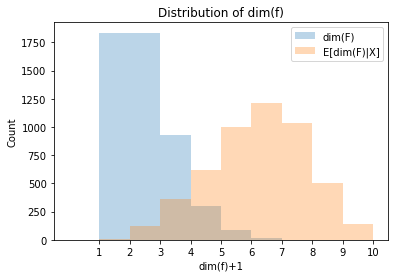

In [42]:
compare_marginals(state.vae, get_batcher(valid_loader, args), args, cols=5, num_samples=num_samples)

## Posterior and Prior Samples

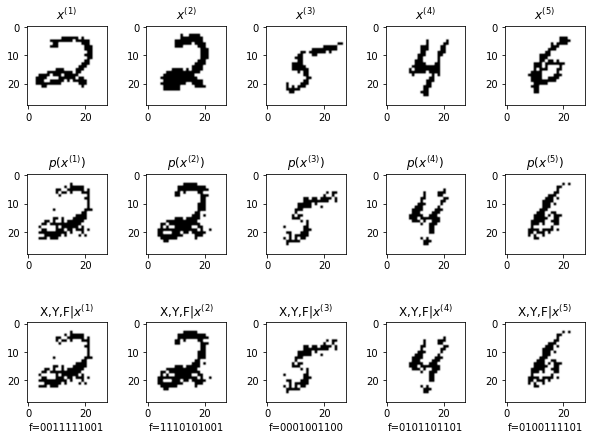

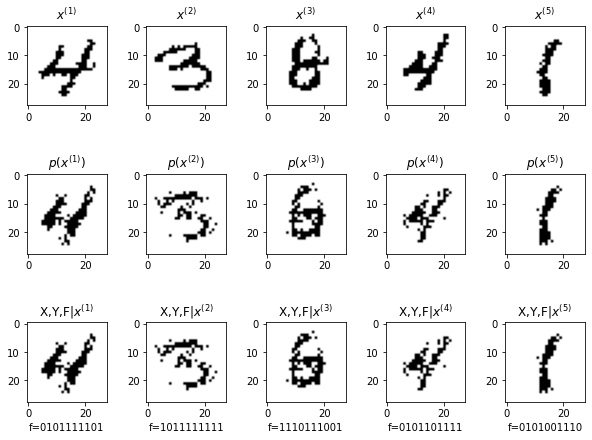

In [43]:
compare_samples(state.vae, get_batcher(valid_loader, args), args, N=5, num_figs=2, num_samples=100)

## TSNE

In [44]:
from analysis import samples_per_digit

In [45]:
f, y, z, x, marginal_f, scores, concs = samples_per_digit(
    state.vae, get_batcher(valid_loader, args, onehot=False), 
    args, return_marginal=args.y_dim > 0)

In [46]:
f.shape, f.mean(1).shape, z.shape, z.mean(1).shape, x.shape, x.mean(1).shape

((10, 458, 10), (10, 10), (10, 458, 0), (10, 0), (10, 458, 784), (10, 784))

In [47]:
marginal_f.shape, marginal_f.mean(1).shape, scores.shape, scores.mean(1).shape, concs.shape, concs.mean(1).shape

((10, 458, 10), (10, 10), (10, 458, 10), (10, 10), (10, 458, 10), (10, 10))

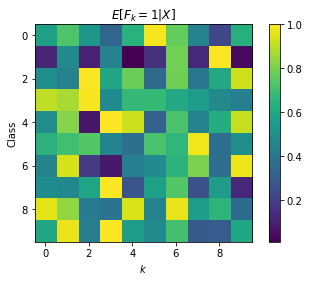

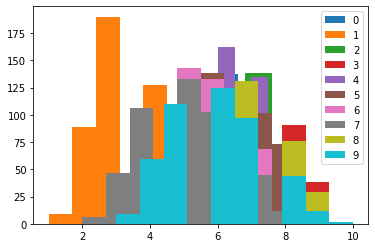

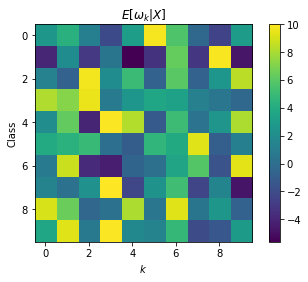

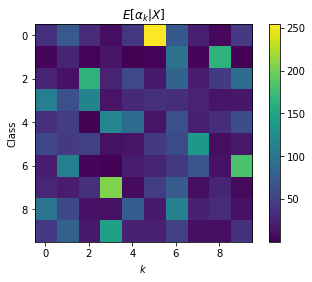

In [48]:
if state.vae.p.y_dim:
    _ = plt.imshow(f.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[F_k = 1|X]$')
    _ = plt.colorbar()
    plt.show()
    
#     _ = plt.imshow(f.sum(-1).mean(1, keepdims=True))
#     _ = plt.ylabel('Class')
#     #_ = plt.xlabel(r'$\max_k$')
#     _ = plt.xticks([], [])
#     _ = plt.title(r'mean argmax')
#     _ = plt.colorbar()
#     plt.show()
    
    for k in range(10):
        _ = plt.hist(f[k].sum(-1), label=f'{k}')
    _ = plt.legend()
    plt.show()
    
    _ = plt.imshow(scores.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[\omega_k|X]$')
    _ = plt.colorbar()
    plt.show()
    
    _ = plt.imshow(concs.mean(1))
    _ = plt.ylabel('Class')
    _ = plt.xlabel(r'$k$')
    _ = plt.title(r'$E[\alpha_k|X]$')
    _ = plt.colorbar()
    plt.show()

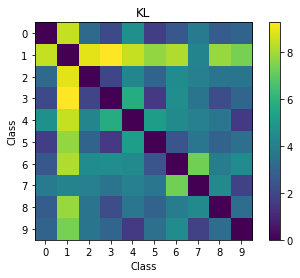

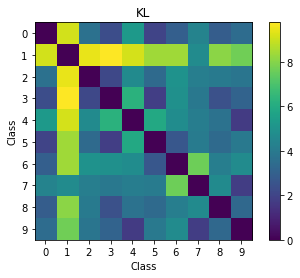

In [49]:
from itertools import product

if state.vae.p.y_dim:
    mc_marginal_f = f.mean(1)
    Fs = [td.Independent(td.Bernoulli(probs=(torch.tensor(mc_marginal_f[c])*0.99 + 1e-4)), 1) for c in range(10)]
    JS_F = np.array([[(0.5*td.kl_divergence(Fs[c], Fs[c_])+0.5*td.kl_divergence(Fs[c_], Fs[c])).numpy() for c_ in range(10)] for c in range(10)])
    #KL_F = np.array([[td.kl_divergence(Fs[c], Fs[c_]).numpy() for c_ in range(10)] for c in range(10)])
    _ = plt.imshow(JS_F)
    _ = plt.ylabel('Class')
    _ = plt.yticks(np.arange(10), np.arange(10))
    _ = plt.xlabel('Class')
    _ = plt.xticks(np.arange(10), np.arange(10))
    _ = plt.title(r'KL')
    _ = plt.colorbar()
    plt.show()
    
    mc_marginal_f = marginal_f.mean(1)
    Fs = [td.Independent(td.Bernoulli(probs=(torch.tensor(mc_marginal_f[c])*0.99 + 1e-4)), 1) for c in range(10)]
    JS_F = np.array([[(0.5*td.kl_divergence(Fs[c], Fs[c_])+0.5*td.kl_divergence(Fs[c_], Fs[c])).numpy() for c_ in range(10)] for c in range(10)])
    #KL_F = np.array([[td.kl_divergence(Fs[c], Fs[c_]).numpy() for c_ in range(10)] for c in range(10)])
    _ = plt.imshow(JS_F)
    _ = plt.ylabel('Class')
    _ = plt.yticks(np.arange(10), np.arange(10))
    _ = plt.xlabel('Class')
    _ = plt.xticks(np.arange(10), np.arange(10))
    _ = plt.title(r'KL')
    _ = plt.colorbar()

In [50]:
from sklearn.manifold import TSNE

In [51]:
def tsne_plot(samples, title, legend=True, filename=None):
    """
    :param samples: [10, N,D]
    """
    assert samples.shape[0] == 10, "I need 10 digits"
    D = samples.shape[-1]
    assert D > 0, "0-dimensional features?"
    tsne_results = TSNE(n_components=2, random_state=1).fit_transform(samples.reshape(-1, D)).reshape(10, -1, 2)
    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple'
    for i, c in zip(np.arange(10), colors):
        plt.scatter(tsne_results[i, :, 0], tsne_results[i, :, 1], c=c, label=i)
    plt.xticks([], [])    
    plt.yticks([], [])
    if legend:
        #plt.legend(bbox_to_anchor=(1, 0.85), loc='upper left', framealpha=0.5)
        plt.legend(loc='upper right', framealpha=1.0)
    #plt.title(title)
    
    if filename:
        plt.savefig(f'{filename}.pdf', bbox_inches='tight') 
    plt.show()

    return tsne_results

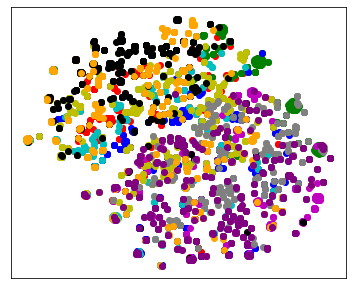

In [52]:
if state.vae.p.y_dim:
    _ = tsne_plot(f, r"$f \sim Q_{F|X=x_{obs}}$", legend=False, filename='tsne_f')

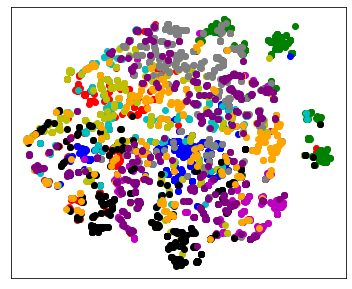

In [53]:
if state.vae.p.y_dim:
    _ = tsne_plot(marginal_f, r"$ \Pr(e_k \in F |X_{obs})$", legend=False, filename='tsne_mu')    

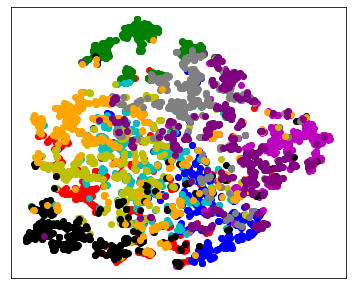

In [54]:
if state.vae.p.y_dim:
    _ = tsne_plot(scores, r"$ w_k \phi_k(f) |X=x_{obs}$", legend=False, filename='tsne_scores')    

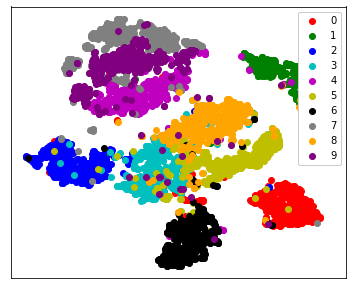

In [55]:
if state.vae.p.y_dim:
    #_ = tsne_plot(f, r"$F|X_{obs}$")
    #_ = tsne_plot(marginal_f, r"$\Pr(k|X_{obs})$")
    _ = tsne_plot(y, r"$y \sim Q_{Y|X=x_{obs}}$", legend=True, filename='tsne_y')

In [56]:
if state.vae.p.z_dim:
    _ = tsne_plot(z, r"$Z|X_{obs}$")

In [57]:
if state.vae.p.z_dim:
    _ = tsne_plot((z > 0) * 1.0, r"$Z > 0 | X_{obs}$")

In [58]:
#if state.vae.p.z_dim:
#    _ = tsne_plot((z > 0.01) * 1.0, r"$Z > 0.01 | X_{obs}$")

In [59]:
if state.vae.p.z_dim:
    _ = plt.hist((z > 0.).sum(-1).flatten(), label="0")
    #_ = plt.hist((z > 0.01).sum(-1).flatten(), label="0.01")
    #_ = plt.hist((z > 0.1).sum(-1).flatten(), label="0.1")
    #_ = plt.hist((z > 0.5).sum(-1).flatten(), label="0.5")
    _ = plt.legend()

In [60]:
import umap

In [61]:
import sklearn

def umap_plot(samples, title, legend=True, filename=None, nbits=None, n_neighbors=5, min_dist=0.1, metric='jaccard'):
    """
    :param samples: [10, N,D]
    """
    assert samples.shape[0] == 10, "I need 10 digits"
    N = samples.shape[1]
    D = samples.shape[-1]
    assert D > 0, "0-dimensional features?"
    
    # [10 * N]
    targets = np.arange(10).repeat(N)
    samples = samples.reshape(-1, D) 
    if nbits is not None:
        ids = (samples > 0).sum(-1) == nbits
        samples = samples[ids]
        targets = targets[ids]
        print(len(samples), 'left')
    tsne_results = umap.UMAP(
       n_neighbors=n_neighbors,
       min_dist=min_dist,
       metric=metric).fit_transform(samples) #jaccard

    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'orange', 'purple'
    for c in range(10):
        ids = targets == c
        plt.scatter(tsne_results[ids, 0], tsne_results[ids, 1], c=colors[c], label=c)
    #for i, c in enumerate(targets):
    #    plt.scatter(tsne_results[i, 0], tsne_results[i, 1], c=colors[c])
    plt.xticks([], [])    
    plt.yticks([], [])
    if legend:
        #plt.legend(bbox_to_anchor=(1, 0.85), loc='upper left', framealpha=0.5)
        plt.legend(loc='upper right', framealpha=1.0)
    #plt.title(title)
    
    if filename:
        plt.savefig(f'{filename}.pdf', bbox_inches='tight') 
    plt.show()

    return tsne_results

1155 left


/home/wferrei1/envs/mixedrv/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/home/wferrei1/envs/mixedrv/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/wferrei1/envs/mixedrv/lib/python3.7/site-packages/umap/spectral.py:256: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


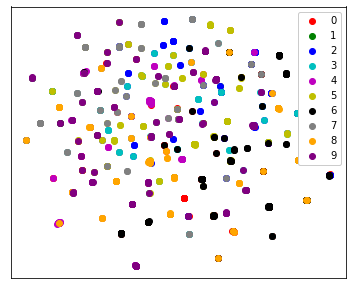

In [62]:
_ = umap_plot(f, 'umap scores', nbits=6, n_neighbors=2)

## Marginal samples per class

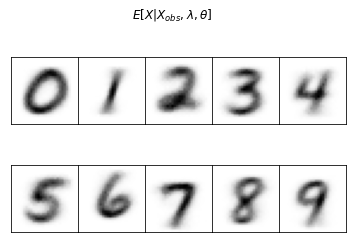

In [63]:
marginal_x = x.mean(1)
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(marginal_x[c].reshape(args.height, args.width), cmap='Greys')
    #axs[c // 5, c % 5].set_title(f"X'|X={c}")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
_ = fig.suptitle(r'$E[X|X_{obs}, \lambda, \theta]$')    

In [64]:
from analysis import probe_corners

In [65]:
corner_samples = probe_corners(state.vae, get_batcher(valid_loader, args), args, num_samples=100)

In [66]:
corner_samples[0]['x'].shape

(100, 784)

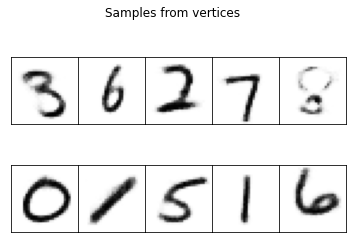

In [67]:
fig, axs = plt.subplots(
    2, 5, 
    sharex=True, sharey=True,
    gridspec_kw={'hspace': 0, 'wspace': 0})
for c in range(10):
    axs[c // 5, c % 5].imshow(corner_samples[c]['x'].mean(0).reshape(args.height, args.width), cmap='Greys')
    #axs[c // 5, c % 5].set_xlabel(c) #set_title(f"X'|X={c}")
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
_ = fig.suptitle(r'Samples from vertices')    

In [ ]:
#np.save(open('to-vlad2-f.npy', 'wb'), f)

In [ ]:
#np.save(open('to-vlad2-marginal.npy', 'wb'), marginal_f)

In [ ]:
#np.save(open('to-vlad2-y.npy', 'wb'), y)

In [ ]:
#np.save(open('to-vlad2-scores.npy', 'wb'), scores)

In [ ]:
#frs = t2s.statistics_nondiff.FRStatistic(p_f.shape[0], q_f.shape[0])

In [ ]:
#frs(torch.tensor(p_f), torch.tensor(q_f), norm=1)